# ROMY Status File

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame
from andbro__save_to_pickle import __save_to_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.load_beat import __load_beat
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals

## Configurations

In [4]:
config = {}


# config['tbeg'] = obs.UTCDateTime(sys.argv[1])
# config['tend'] = obs.UTCDateTime(sys.argv[1])+86400

config['tbeg'] = obs.UTCDateTime("2024-04-29")
config['tend'] = obs.UTCDateTime("2024-04-30")

config['ring'] = "U"

config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figures'] = archive_path+f"romy_plots/{config['tbeg'].year}/R{config['ring']}/status/"

config['path_to_output'] = archive_path+f"temp_archive/{config['tbeg'].year}/BW/R{config['ring']}/"

config['fsagnac_rings'] = {"U":303, "V":447.5, "W":447.5, "Z":553.5}
config['fsagnac_nominal'] = config['fsagnac_rings'][config['ring']]

config['DC_threshold'] = 0.1

config['AC_threshold'] = 0.3


### Load MLTI Logs

In [5]:
mlti_log = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti_log.time_utc, time_delta=100)

In [6]:
mlti_log.size

39

### Load Beat Data

In [7]:
beat = __load_beat(config['tbeg'], config['tend'], config['ring'], config['path_to_autodata'])

In [8]:
beat = beat.reset_index()

### Define Variables

In [9]:
status = DataFrame()

status['times_utc'] = beat.times_utc
status['times_utc_sec'] = beat.times_utc_sec

N = status.shape[0]

quality = np.ones(N)
fsagnac = np.ones(N)
mlti = np.ones(N)
dc_threshold = np.ones(N)
ac_threshold = np.ones(N)

## Determine Status

In [10]:
idx_mlti = 0

for idx in range(beat.shape[0]):

    _time = obs.UTCDateTime(status.times_utc.iloc[idx])

    ## check if time conincides with MLTI
    # print(_time, mlti_t1[idx_mlti], mlti_t2[idx_mlti])
    if len(mlti_t1) > 0 and len(mlti_t2) > 0:
        if _time >= mlti_t1[idx_mlti] and _time <= mlti_t2[idx_mlti]:
            quality[idx] = 0
            mlti[idx] = 0

        ## update mlti interval
        if _time > mlti_t2[idx_mlti] and idx_mlti < len(mlti_t1)-1:
            idx_mlti += 1

    if beat.fj.iloc[idx] < config['fsagnac_nominal'] - 1.0 or beat.fj.iloc[idx] > config['fsagnac_nominal'] + 1.0:
        quality[idx] = 0
        fsagnac[idx] = 0

    if beat.dc_z.iloc[idx] < config['DC_threshold']:
        quality[idx] = 0
        dc_threshold[idx] = 0

    if beat.ac_z.iloc[idx] < config['AC_threshold']:
        quality[idx] = 0
        ac_threshold[idx] = 0


status['quality'] = quality
status['fsagnac'] = fsagnac
status['mlti'] = mlti
status['ac_threshold'] = ac_threshold
status['dc_threshold'] = dc_threshold


## store output to file
print(f"-> store: {config['path_to_output']}R{config['ring']}_{config['tbeg'].date}_status.pkl")
__save_to_pickle(status, config['path_to_output'],f"R{config['ring']}_{config['tbeg'].date}_status")


-> store: /import/freenas-ffb-01-data/temp_archive/2024/BW/RU/RU_2024-04-29_status.pkl

 -> created:  /import/freenas-ffb-01-data/temp_archive/2024/BW/RU/RU_2024-04-29_status.pkl


### Plotting

In [11]:
arr = np.ones((3, status['quality'].size))

arr[0] *= status['quality']
arr[1] *= status['fsagnac']
arr[2] *= status['mlti']

/tmp/ipykernel_2552842/3793813834.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


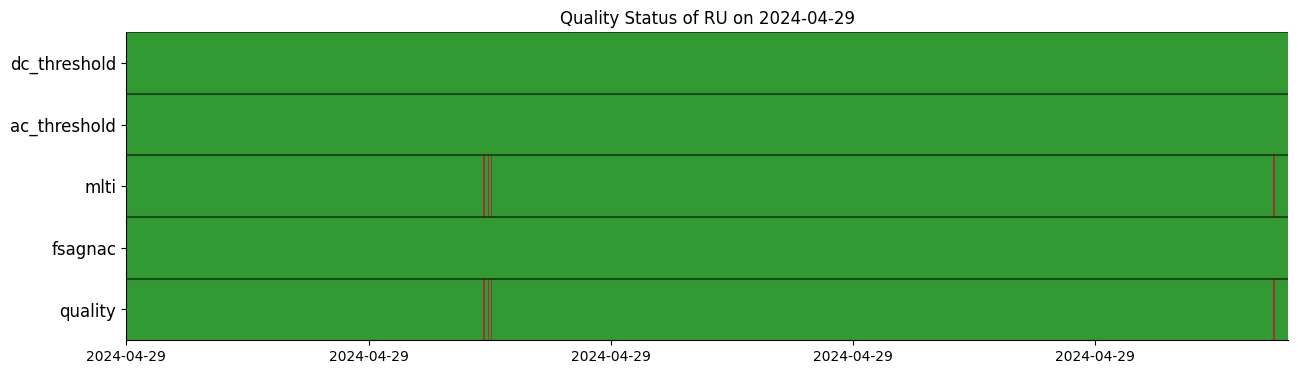

In [12]:
names = ["quality", "fsagnac", "mlti", "ac_threshold", "dc_threshold"]
bars = np.ones(len(names))-0.5

arr = np.ones((len(names), status['quality'].size))

for _n, name in enumerate(names):
    arr[_n] *= status[name]


cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

font = 12

fig, ax = plt.subplots(1, 1, figsize=(15, 4))


c = ax.pcolormesh(np.arange(0, arr.shape[1])/60, names, arr, cmap=cmap,
                  rasterized=True, alpha=0.8, antialiased=False)

# c = ax.pcolor(beat.times_utc_sec, names, arr, cmap=cmap,
#               rasterized=True, alpha=0.8, antialiased=False)

for _k, bar in enumerate(bars):
    ax.axhline(bar+_k, color="k", alpha=0.5)

# ax.set_xlabel("Time (min)")

ref_date = beat.times_utc.iloc[0]
tcks = ax.get_xticks()
tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
ax.set_xticklabels(tcklbls)

ax.tick_params(axis='y', labelsize=font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title(f"Quality Status of R{config['ring']} on {config['tbeg'].date}")

plt.show();


# print(f" -> stored: {config['path_to_figures']}R{config['ring']}_{config['tbeg'].date}_status.png")
# fig.savefig(config['path_to_figures']+f"R{config['ring']}_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')